In [1]:
from funcs.ffd import FFD, generate_random_power_law_distribution

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

## Create an FFD object

Let's create a power law distributed sample of flare energies with exponent $\alpha=-2$

A simple FFD of only one star where we assume to have correct energies, no observational biases, and a clear detection threshold at $ED=10$ s.

In [2]:
# a, b, g, size = energy lower and upper limit, power law exponent +1, number of flares
pwl = generate_random_power_law_distribution(10, 1e3, -1, size=200, seed=80)
simple_ffd = FFD(f=pd.DataFrame({"ed_rec":pwl}))
simple_ffd.f.head()

,ed_rec
0,20.690935
1,32.511053
2,13.645735
3,30.096645
4,99.001434


## Plot the FFD

In [3]:
ed, freq, counts = simple_ffd.ed_and_freq()

Setting ED with new values, size 200.
Setting frequency values with new values, size 200.
Setting frequency adjusted count values with new values, size 200.


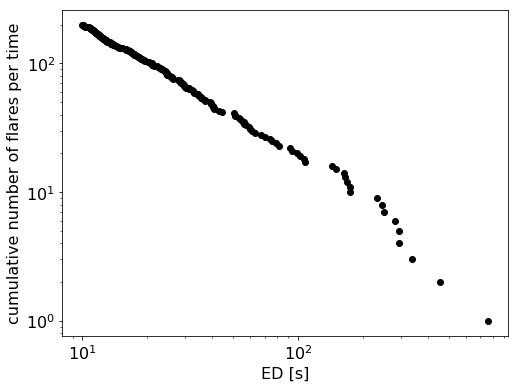

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(ed, freq, c="k")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("ED [s]")
plt.ylabel("cumulative number of flares per time");

## Fit powerlaw

In [5]:
simple_ffd.alpha, simple_ffd.alpha_err = simple_ffd.fit_powerlaw()

In [6]:
simple_ffd.alpha, simple_ffd.alpha_err

(1.963553855895996, 0.08012203082491737)

## Fit intercept to powerlaw with known exponent

In [7]:
betas, simple_ffd.beta, simple_ffd.beta_err = simple_ffd.fit_beta_to_powerlaw()

In [8]:
simple_ffd.beta, simple_ffd.beta_err

(1753.1677389526367, 140.50464845948764)

## Plot the power law

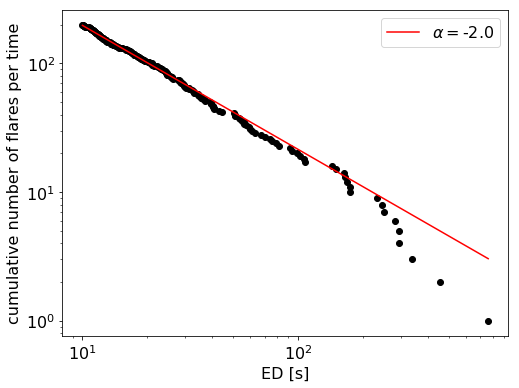

In [9]:
fig, ax = plt.subplots(1,figsize=(8,6))
ax.scatter(ed, freq, c="k")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("ED [s]")
ax.set_ylabel("cumulative number of flares per time")
simple_ffd.plot_powerlaw(ax, c="r",label=fr'$\alpha=$-{simple_ffd.alpha:.1f}')
plt.legend();

## Is this distribution a powerlaw?

In [10]:
simple_ffd.is_powerlaw()

True

## Is this power law distribution truncated at the upper energy limit?

In [11]:
simple_ffd.is_powerlaw_truncated()

False

This distribution is consistent with a power law that is not truncated.

Let's create a truncated version and see if it works:

In [12]:
f=pd.DataFrame({"ed_rec":pwl})
simple_truncated_ffd = FFD(f=f[f.ed_rec<200])#truncate at 200s 
simple_truncated_ffd.alpha = 2.
ed, freq, counts = simple_truncated_ffd.ed_and_freq()

Setting ED with new values, size 191.
Setting frequency values with new values, size 191.
Setting frequency adjusted count values with new values, size 191.


In [13]:
simple_truncated_ffd.is_powerlaw_truncated()

True

*You can play with the truncation limit and sample size to get a feeling for the sensitivity of the test given the sample size.*

## Correct for energy ratio, recovery probability, and detection thresholds

Let's now generate a sample of flares that stem from different stars with different detection thresholds. They shall also have some observational bias:

In [44]:
# energy upper limit, power law exponent +1, number of flares
b, g, size = 1e8, -1, 30
df = pd.DataFrame()
for a in [60,100,8,90,16,220,110,50,22,80,#65,105,23,96,21,327,117,7,27,85,
          ]: # minimum detected flare energy
    pwls = generate_random_power_law_distribution(float(a), b, g, size=size)
    df = df.append(pd.DataFrame({
                                # power law distributed detected flare energies
                                "ed_rec":pwls,
                                # true flare energies are typically larger than the detected ones
                                "ed_corr":pwls*1.,
                                #maximum recovery probability is 1, otherwise 0-1
                                "recovery_probability":1 ,
                                #different targets have different detection thresholds
                                "TIC":a,
                    }))
multi_ffd = FFD(f=df, ID="TIC", tot_obs_time=5.)
multi_ffd.f.head()

,ed_rec,ed_corr,recovery_probability,TIC
0,111.142669,111.142669,1,60
1,146.662367,146.662367,1,60
2,88.394412,88.394412,1,60
3,60.171209,60.171209,1,60
4,69.881928,69.881928,1,60


Setting ED with new values, size 300.
Setting frequency values with new values, size 300.
Setting frequency adjusted count values with new values, size 300.
Setting ED with new values, size 300.
Setting frequency values with new values, size 300.
Setting frequency adjusted count values with new values, size 300.
Setting ED with new values, size 300.
Setting frequency values with new values, size 300.
Setting frequency adjusted count values with new values, size 300.
Setting ED with new values, size 300.
Setting frequency values with new values, size 300.
Setting frequency adjusted count values with new values, size 802.


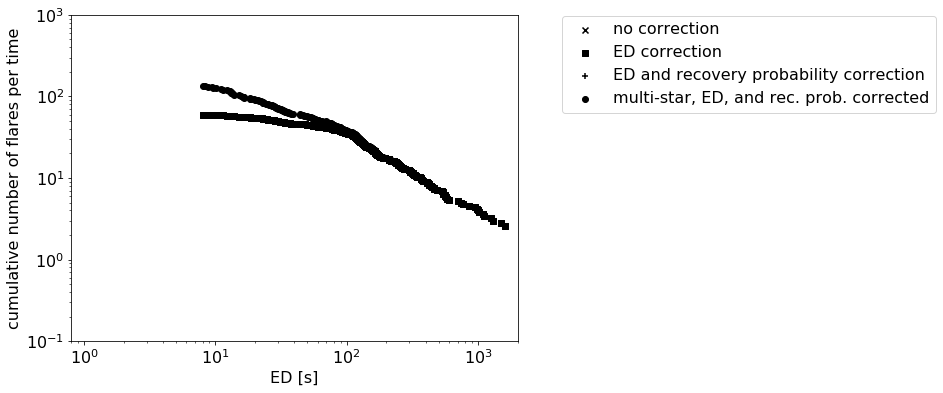

In [45]:
fig, ax = plt.subplots(1,figsize=(8,6))


ed, freq, counts = multi_ffd.ed_and_freq()

ax.scatter(ed, freq, c="k", marker="x",label="no correction")

ed, freq, counts = multi_ffd.ed_and_freq(energy_correction=True)
ax.scatter(ed, freq, c="k",marker="s", label="ED correction")

ed, freq, counts = multi_ffd.ed_and_freq(energy_correction=True,
                                         recovery_probability_correction=True)

ax.scatter(ed, freq, c="k",marker="+", label="ED and recovery probability correction")

ed, freq, counts = multi_ffd.ed_and_freq(energy_correction=True,
                                         recovery_probability_correction=True,
                                        multiple_stars=True)

ax.scatter(ed, freq, c="k", label="multi-star, ED, and rec. prob. corrected")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("ED [s]")
ax.set_ylabel("cumulative number of flares per time")
ax.set_xlim(.8,2e3)
ax.set_ylim(.1,1e3)
plt.legend(loc=(1.1,.7));

In [46]:
multi_ffd.fit_powerlaw(count_ed=True)
multi_ffd.alpha, multi_ffd.alpha_err

(1.4800010275067828, 0.018000877753944346)

*The uncertainty on $\alpha$ should not be used here, because the sample was blown up artificially.*

In [41]:
betas, multi_ffd.beta, multi_ffd.betas_err = multi_ffd.fit_beta_to_powerlaw()
multi_ffd.beta, multi_ffd.betas_err

(14.00111083984375, 1.0656671770756236)

1.3579648724039086 14.00111083984375
Setting ED with new values, size 50.
Setting frequency values with new values, size 50.
Setting frequency adjusted count values with new values, size 131.
2 298.93129638671877


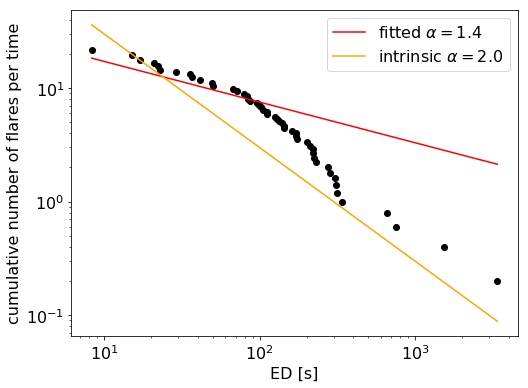

In [42]:
fig, ax = plt.subplots(1,figsize=(8,6))
ax.scatter(multi_ffd.ed, multi_ffd.freq, c="k")
print(multi_ffd.alpha, multi_ffd.beta)
multi_ffd.plot_powerlaw(ax,c="r",label=fr"fitted $\alpha={multi_ffd.alpha:.1f}$")

#overplot the intrinsic distribution
multi_ffd2 = FFD(f=df, ID="TIC", tot_obs_time=5.)
ed, freq, counts = multi_ffd2.ed_and_freq(energy_correction=True,
                                         recovery_probability_correction=True,
                                        multiple_stars=True)
multi_ffd2.alpha, multi_ffd2.alpha_err = -g+1, .1
betas, multi_ffd2.beta, multi_ffd2.betas_err = multi_ffd2.fit_beta_to_powerlaw()
print(multi_ffd2.alpha, multi_ffd2.beta)
multi_ffd2.plot_powerlaw(ax,c="orange",label=fr"intrinsic $\alpha={multi_ffd2.alpha:.1f}$")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("ED [s]")
plt.ylabel("cumulative number of flares per time")
plt.legend();

Let's test if the two solutions are consistent with a power law.

In [43]:
multi_ffd.is_powerlaw(count_ed=True), multi_ffd2.is_powerlaw(count_ed=True)

/home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/notebook/funcs/ffd.py:394: UserWarning: Kolmogorov-Smirnov tells us to reject the power law hypothesis at p=0.05. KS=0.20712410112897328, limit=0.19206455826398416
  ' KS={}, limit={}'.format(sig_level, KS, limit))
/home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/notebook/funcs/ffd.py:394: UserWarning: Kolmogorov-Smirnov tells us to reject the power law hypothesis at p=0.05. KS=0.3578298707931935, limit=0.19206455826398416
  ' KS={}, limit={}'.format(sig_level, KS, limit))


(False, False)

In [37]:
multi_ffd.is_powerlaw_truncated(count_ed=True), multi_ffd2.is_powerlaw_truncated(count_ed=True)

(False, False)